In [1]:
import pandas as pd
import numpy as np
import networkx as nx
# import geopandas as gpd
import torch
import math
import os 
import sys

from botorch.acquisition.analytic import PosteriorMean
from botorch.test_functions.synthetic import Hartmann, Rosenbrock

torch.set_default_dtype(torch.float64)

from botorch.optim import optimize_acqf_discrete
from copy import deepcopy

cwd = os.getcwd()
sys.path.append("/".join(cwd.split("/")[:-2]))

from src.bax.alg.dijkstra import Dijkstra
from src.bax.util.domain_util import unif_random_sample_domain
from src.bax.util.graph import make_grid, edges_of_path, positions_of_path, area_of_polygons
from src.acquisition_functions.posterior_sampling import gen_posterior_sampling_batch
from src.acquisition_functions.bax_acquisition import BAXAcquisitionFunction
from src.fit_model import fit_model

/opt/conda/envs/PSBAX/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:

input_dim = 2
grid_size = 10
x1_lims = (-2, 2)
x2_lims = (-1, 4)

rescaled_x1_lims = (0, 1)
rescaled_x2_lims = (0, 1)
positions, vertices, edges = make_grid(grid_size, rescaled_x1_lims, rescaled_x2_lims)
start, goal = vertices[-grid_size], vertices[-1]


def create_mesh(xmin, xmax, steps=20):
    length = xmax - xmin
    # xlim = [xmin - 0.05 * length, xmax + 0.05 * length]
    # ax = torch.linspace(xlim[0], xlim[1], steps)
    ax = torch.linspace(xmin - 0.05 * length, xmax + 0.05 * length, steps)
    xx = torch.meshgrid(ax, ax, indexing="ij")
    return xx

def reshape_mesh(xx):
    x1 = xx[0].reshape(-1)
    x2 = xx[1].reshape(-1)
    return torch.stack([x1, x2], dim=1)

def rosenbrock(x, y, a=1, b=100):
    # NOTE rescaled to improve numerics
    # NOTE min cost path: 1.0527267184880365
    return 1e-2 * ((a - x)**2 + b * (y - x**2)**2)

def true_f(x_y):
    x_y = np.array(x_y).reshape(-1)
    return rosenbrock(x_y[..., 0], x_y[..., 1])

def inv_softplus(x):
    return np.log(np.exp(x) - 1)

# NOTE: this is the function we will use
def true_latent_f(x_y):
    '''
    Args:
        x_y: np.array (n_dim, )
    '''
    return inv_softplus(true_f(x_y))

def softplus(x):
    return np.log1p(np.exp(x))

def obj_func(X, problem="rosenbrock", rescaled=True, minimize=True, bounds=[x1_lims, x2_lims], latent_f=True):
    '''
    Args:
        X: (1, n_dim)
    Returns:
        torch.tensor : (1, 1) for botorch model fitting
    '''
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X).reshape(-1, 2)
    X_rescaled = X.clone()
    # Scale X to bounds
    for i in range(X_rescaled.shape[-1]):
        X_rescaled[:, i] = X_rescaled[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]

    if problem == "rosenbrock":
        f = Rosenbrock(dim=input_dim)
    else:
        raise NotImplementedError
    
    f_X = f.evaluate_true(X_rescaled)
    if rescaled:
        f_X = 1e-2 * f_X
    if not minimize:
        f_X = -f_X
    
    def inv_softplus(x):
        return torch.log(torch.exp(x) - 1)
    
    return inv_softplus(f_X)
     
def cost_func(u, v, f, latent_f=True):
    u_pos, v_pos = u.position, v.position
    edge = (u_pos + v_pos) / 2
    edge_cost = f(edge)
    if latent_f:
        return softplus(edge_cost), [edge], [edge_cost]
    else:
        return edge_cost, [edge], [edge_cost]

# algo_params = {
#     'cost_func': lambda u, v, f: cost_func(u, v, f, latent_f=True),
#     'true_cost': lambda u, v: cost_func(u, v, true_f, latent_f=False)
# }
algo_params = {
    'cost_func': lambda u, v, f: cost_func(u, v, f, latent_f=True),
    'true_cost': lambda u, v: cost_func(u, v, obj_func, latent_f=True)
}
algo = Dijkstra(algo_params, vertices, start, goal)

algo_metric = algo.get_copy()
# performance_metrics = [
#     ShortestPathCost(algo_metric),
#     ShortestPathArea(algo_metric, obj_func),
# ]


In [57]:
problem_dir = os.path.join(cwd, "results/dijkstra") 
bax_dir = os.path.join(problem_dir, "bax_1")
ps_dir = os.path.join(problem_dir, "ps_1")

policy = "ps"
dir = os.path.join(problem_dir, f"{policy}_1")
trial = 11
end_iter = 50
inputs = np.loadtxt(os.path.join(dir, "inputs", f"inputs_{trial}.txt"))
obj_vals = np.loadtxt(os.path.join(dir, "obj_vals", f"obj_vals_{trial}.txt"))
inputs = torch.from_numpy(inputs)
obj_vals = torch.from_numpy(obj_vals)
if end_iter is not None:
    inputs = inputs[:end_iter]
    obj_vals = obj_vals[:end_iter]
kwargs = {}
model = fit_model(
    inputs,
    obj_vals,
    model_type="gp",
    **kwargs
)

In [58]:
algo_gt = algo.get_copy()
exe_path_gt, output_gt = algo_gt.run_algorithm_on_f(obj_func)

posterior_mean_func = PosteriorMean(model)
exe_path_mf, output_mf = algo.run_algorithm_on_f(posterior_mean_func)


In [59]:
vertex_positions = [v.position for v in vertices]
P_vertices = [output_mf[-1][i].position for i in range(len(output_mf[-1]))]
P_vertices = np.array(P_vertices)
P_edges = edges_of_path(output_mf[-1])

gt_vertices = positions_of_path(output_gt[-1])
gt_edges = edges_of_path(output_gt[-1])

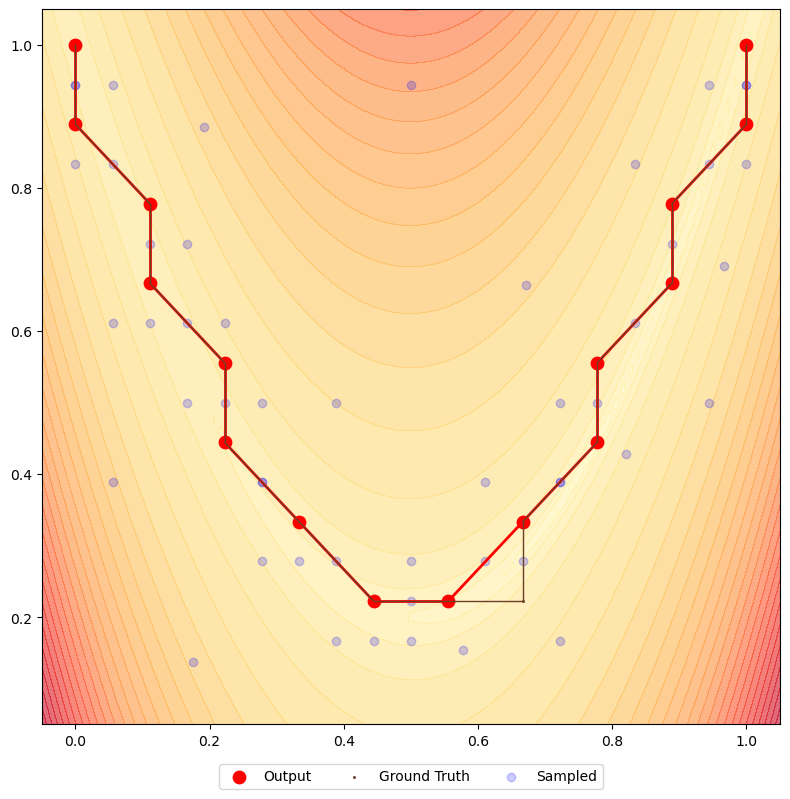

In [66]:
import matplotlib.pyplot as plt
xx = create_mesh(0, 1, 100)
X = reshape_mesh(xx)
cost = obj_func(X)

fig, ax = plt.subplots(figsize=(8, 8))

c = ax.contourf(
    xx[0], 
    xx[1], 
    cost.reshape(100, 100), 
    levels=40,
    alpha=0.6, 
    cmap="YlOrRd"
)
# plt.colorbar(c)


ax.scatter(
    P_vertices[:, 0], 
    P_vertices[:, 1], 
    color = "red",
    marker="o",
    s=80,
    # alpha=0.5,
    label="Output"
)
for i in range(len(P_edges)):
    edge = np.array(P_edges[i])
    ax.plot(
        edge[:, 0], 
        edge[:, 1], 
        color="red",
        linestyle="-",
        linewidth=2,
    )
# ax.set_title(f"{policy}")

ax.scatter(
    gt_vertices[:, 0],
    gt_vertices[:, 1],
    c="#6B3E26",
    marker=".",
    s=5,
    # alpha=0.5,
    label="Ground Truth",
)
for i in range(len(gt_edges)):
    edge = np.array(gt_edges[i])
    ax.plot(
        edge[:, 0], 
        edge[:, 1], 
        color="#6B3E26",
        linestyle="-",
        linewidth=1,
    )

ax.scatter(
    inputs[:, 0], 
    inputs[:, 1], 
    color = "blue", 
    marker="o",
    alpha=0.2,
    label="Sampled"
)

ax.set_ylim([0.05, 1.05])

ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=len(ax.get_legend_handles_labels()[-1]))
plt.tight_layout()
plt.savefig(
    f"{policy}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

([<matplotlib.collections.PathCollection at 0x7fe8f8d07150>,
 ['Output', 'Ground Truth', 'Sampled'])

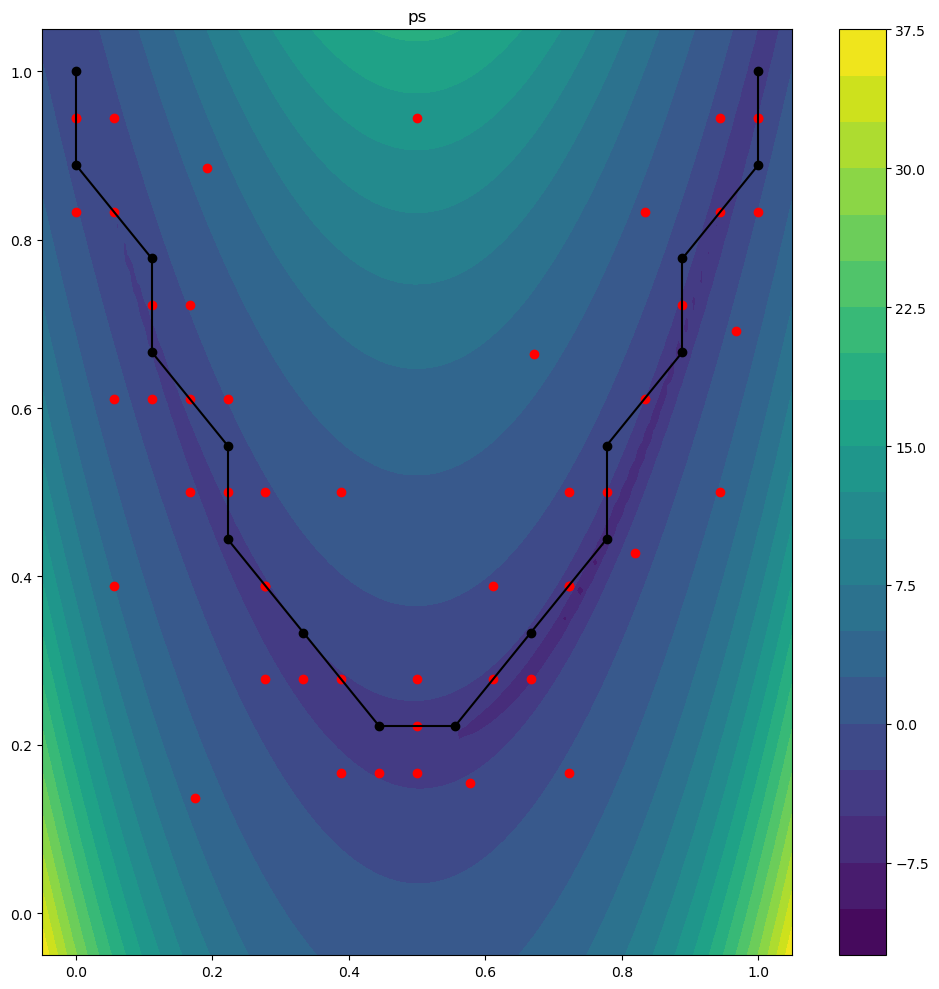

In [64]:
import matplotlib.pyplot as plt
xx = create_mesh(0, 1, 100)
X = reshape_mesh(xx)
cost = obj_func(X)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

c = ax.contourf(xx[0], xx[1], cost.reshape(100, 100), levels=20)
plt.colorbar(c)
ax.plot(inputs[:, 0], inputs[:, 1], "ro", label="sampled")
# plt.plot(exe_path_gt[:, 0], exe_path_gt[:, 1], "g-")

ax.scatter(P_vertices[:, 0], P_vertices[:, 1], color=(0, 0, 0, 1))
for i in range(len(P_edges)):
    edge = np.array(P_edges[i])
    ax.plot(edge[:, 0], edge[:, 1], "k-")
ax.set_title(f"{policy}")
plt.tight_layout()
plt.savefig(
    f"{policy}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()



In [ ]:
# P_edges = edges_of_path(output_mf)
